In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

class BeachSegmentationDataset(Dataset):
    """Dataset class for beach scene segmentation"""
    
    CLASSES = [
        "background",
        "cobbles",
        "drysand",
        "plant",
        "sky",
        "water",
        "wetsand"
    ]
    
    # Define color mapping for different classes, used for visualization
    COLOR_MAP = {
        0: [0, 0, 0],        # background - black
        1: [139, 137, 137],  # cobbles - dark gray
        2: [255, 228, 181],  # dry sand - light yellow
        3: [0, 128, 0],      # plant - green
        4: [135, 206, 235],  # sky - sky blue
        5: [0, 0, 255],      # water - blue
        6: [194, 178, 128]   # wet sand - sandy brown
    }

    def __init__(self, images_dir, masks_dir, augmentation=None):
        self.ids = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # Modify mask file path construction
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '_mask.png')) for image_id in self.ids]
        self.augmentation = augmentation

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # No need to merge classes, use original annotations
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
        # Transpose to CHW format and convert to float32 type
        image = image.transpose(2, 0, 1).astype('float32')
        mask = mask.astype('int64')
        return image, mask, self.images_fps[i]  # Add return image file path for visualization

    def __len__(self):
        return len(self.ids)

def get_training_augmentation(image_size=1024):
    # Remove always_apply parameter
    train_transform = [
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
    return A.Compose(train_transform)

def get_validation_augmentation(image_size=1024):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

class BeachSegmentationModel(pl.LightningModule):
    def __init__(self, arch="DeepLabV3Plus", encoder_name="efficientnet-b7", in_channels=3, out_classes=7, learning_rate=1e-4):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            encoder_weights="imagenet"  # Use pretrained weights
        )
        # Use combined loss function: Dice Loss + Focal Loss to improve segmentation accuracy
        self.dice_loss = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        self.focal_loss = smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, gamma=2.0)
        self.number_of_classes = out_classes
        self.learning_rate = learning_rate
        
        # Save hyperparameters for later loading
        self.save_hyperparameters()

    def forward(self, image):
        return self.model(image)

    def shared_step(self, batch, stage):
        image, mask = batch[:2]  # Only take the first two elements, ignore file path
        assert image.ndim == 4
        assert mask.ndim == 3
        
        # Get model predictions
        logits_mask = self.forward(image)
        
        # Calculate composite loss
        dice_loss = self.dice_loss(logits_mask, mask)
        focal_loss = self.focal_loss(logits_mask, mask)
        loss = dice_loss * 0.7 + focal_loss * 0.3  # Weighted combination
        
        # Calculate performance metrics
        prob_mask = logits_mask.softmax(dim=1)
        pred_mask = prob_mask.argmax(dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask,
            mask,
            mode="multiclass",
            num_classes=self.number_of_classes,
        )
        
        # Calculate IoU and F1 scores
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        
        # Record all metrics
        metrics = {
            "loss": loss,
            "dice_loss": dice_loss,
            "focal_loss": focal_loss,
            "iou_score": iou_score,
            "f1_score": f1_score,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn
        }
        
        return metrics

    def training_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "train")
        # Log training metrics
        self.log("train_loss", metrics["loss"], on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_iou", metrics["iou_score"], on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_f1", metrics["f1_score"], on_step=False, on_epoch=True)
        return metrics

    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "valid")
        # Log validation metrics
        self.log("valid_loss", metrics["loss"], on_step=False, on_epoch=True, prog_bar=True)
        self.log("valid_iou", metrics["iou_score"], on_step=False, on_epoch=True, prog_bar=True)
        self.log("valid_f1", metrics["f1_score"], on_step=False, on_epoch=True)
        return metrics

    def test_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "test")
        # Log test metrics
        self.log("test_loss", metrics["loss"], on_step=False, on_epoch=True)
        self.log("test_iou", metrics["iou_score"], on_step=False, on_epoch=True)
        self.log("test_f1", metrics["f1_score"], on_step=False, on_epoch=True)
        return metrics

    def configure_optimizers(self):
        # Use AdamW optimizer, usually performs better than Adam for image tasks
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate,
            weight_decay=1e-4
        )
        
        # Use cosine annealing warm restarts scheduler
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=10,  # First restart cycle length
            T_mult=1,  # Subsequent cycle coefficient
            eta_min=1e-6  # Minimum learning rate
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "valid_loss"
            },
        }

def visualize_predictions(model, dataset, device, num_samples=4, save_dir="predictions"):
    """Visualize model prediction results"""
    os.makedirs(save_dir, exist_ok=True)
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for i, (image, mask, filepath) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            # Move data to device
            image = image.to(device)
            mask = mask.to(device)
            
            # Get predictions
            logits = model(image)
            prob_mask = logits.softmax(dim=1)
            pred_mask = prob_mask.argmax(dim=1)
            
            # Convert to CPU and numpy
            image = image.cpu().numpy().squeeze().transpose(1, 2, 0)
            mask = mask.cpu().numpy().squeeze()
            pred_mask = pred_mask.cpu().numpy().squeeze()
            
            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            
            # Create color masks
            color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            color_pred_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
            
            for cls, color in dataset.COLOR_MAP.items():
                color_mask[mask == cls] = color
                color_pred_mask[pred_mask == cls] = color
            
            # Create visualization
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(color_mask)
            plt.title("Ground Truth")
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(color_pred_mask)
            plt.title("Prediction")
            plt.axis('off')
            
            # Get filename
            filename = os.path.basename(filepath[0])
            plt.savefig(os.path.join(save_dir, f"prediction_{filename}.png"))
            plt.close()

def train_model(data_dir="data", image_size=1024, batch_size=4, epochs=100, num_workers=0):
    # Set data directories
    x_train_dir = os.path.join(data_dir, "train")
    y_train_dir = os.path.join(data_dir, "train")
    x_valid_dir = os.path.join(data_dir, "valid")
    y_valid_dir = os.path.join(data_dir, "valid")
    x_test_dir = os.path.join(data_dir, "test")
    y_test_dir = os.path.join(data_dir, "test")

    # Create datasets
    train_dataset = BeachSegmentationDataset(
        x_train_dir, y_train_dir,
        augmentation=get_training_augmentation(image_size),
    )
    valid_dataset = BeachSegmentationDataset(
        x_valid_dir, y_valid_dir,
        augmentation=get_validation_augmentation(image_size),
    )
    test_dataset = BeachSegmentationDataset(
        x_test_dir, y_test_dir,
        augmentation=get_validation_augmentation(image_size),
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )

    # Create model
    model = BeachSegmentationModel(
        arch="DeepLabV3Plus",
        encoder_name="efficientnet-b6",  # Use EfficientNetB6
        in_channels=3,
        out_classes=len(train_dataset.CLASSES),
        learning_rate=8e-5  # Adjusted learning rate for EfficientNet B6 with small batch size
    )

    # Create callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="valid_iou",  # Monitor IoU instead of loss
        mode="max",  # Maximize IoU 両翼のBrilliance
        filename="best_model-{epoch:02d}-{valid_iou:.4f}",
        save_top_k=3,
        verbose=True,
    )
    
    early_stopping = EarlyStopping(
        monitor="valid_loss",
        patience=15,  # Stop if no improvement for 15 epochs 
        mode="min",
        verbose=True
    )

    # Create trainer
    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        precision="16-mixed",  # Use mixed precision training for acceleration
        log_every_n_steps=10,
        callbacks=[checkpoint_callback, early_stopping],
        gradient_clip_val=1.0,  # Gradient clipping to prevent explosion
    )

    # Train model
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
    )

    # Test model
    test_results = trainer.test(model, dataloaders=test_loader)
    
    # Visualize some prediction results
    device = "cuda" if torch.cuda.is_available() else "cpu"
    visualize_predictions(model, test_dataset, device, num_samples=8, save_dir="prediction_results")
    
    return model, trainer, checkpoint_callback.best_model_path, test_results

if __name__ == "__main__":
    # Set random seed for reproducibility
    pl.seed_everything(42)
    
    # Start training
    model, trainer, best_model_path, test_results = train_model(
        data_dir="data",
        image_size=1024,
        batch_size=2,  # Reduced batch size to 2
        epochs=100,
        num_workers=0  # Use 0 for Windows systems
    )
    
    print(f"Best model saved at: {best_model_path}")
    print(f"Test results: IoU={test_results[0]['test_iou']:.4f}, F1={test_results[0]['test_f1']:.4f}")
    print("Training completed!")

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric valid_loss improved. New best score: 0.246
Epoch 0, global step 258: 'valid_iou' reached 0.88111 (best 0.88111), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=00-valid_iou=0.8811.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.191
Epoch 1, global step 516: 'valid_iou' reached 0.89686 (best 0.89686), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=01-valid_iou=0.8969.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.176
Epoch 2, global step 774: 'valid_iou' reached 0.90793 (best 0.90793), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=02-valid_iou=0.9079.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.172
Epoch 3, global step 1032: 'valid_iou' reached 0.90526 (best 0.90793), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=03-valid_iou=0.9053.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.161
Epoch 4, global step 1290: 'valid_iou' reached 0.91284 (best 0.91284), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=04-valid_iou=0.9128.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1548: 'valid_iou' reached 0.91342 (best 0.91342), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=05-valid_iou=0.9134.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1806: 'valid_iou' reached 0.91535 (best 0.91535), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=06-valid_iou=0.9154.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.161
Epoch 7, global step 2064: 'valid_iou' reached 0.91473 (best 0.91535), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=07-valid_iou=0.9147.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.160
Epoch 8, global step 2322: 'valid_iou' reached 0.91525 (best 0.91535), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=08-valid_iou=0.9152.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.160
Epoch 9, global step 2580: 'valid_iou' reached 0.91536 (best 0.91536), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=09-valid_iou=0.9154.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 2838: 'valid_iou' reached 0.91674 (best 0.91674), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=10-valid_iou=0.9167.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.152
Epoch 11, global step 3096: 'valid_iou' reached 0.92301 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=11-valid_iou=0.9230.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 3354: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 3612: 'valid_iou' reached 0.92127 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=13-valid_iou=0.9213.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 3870: 'valid_iou' reached 0.92104 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=14-valid_iou=0.9210.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 4128: 'valid_iou' reached 0.92121 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=15-valid_iou=0.9212.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 4386: 'valid_iou' reached 0.92193 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=16-valid_iou=0.9219.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 4644: 'valid_iou' reached 0.92154 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=17-valid_iou=0.9215.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 4902: 'valid_iou' reached 0.92168 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=18-valid_iou=0.9217.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 5160: 'valid_iou' reached 0.92180 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=19-valid_iou=0.9218.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 5418: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 5676: 'valid_iou' reached 0.92221 (best 0.92301), saving model to 'c:\\Users\\xhc42\\Desktop\\SJ\\lightning_logs\\version_0\\checkpoints\\best_model-epoch=21-valid_iou=0.9222.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 5934: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 6192: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 6450: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 6708: 'valid_iou' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_loss did not improve in the last 15 records. Best score: 0.152. Signaling Trainer to stop.
Epoch 26, global step 6966: 'valid_iou' was not in top 3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\programs\Anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9661709666252136     │
│         test_iou          │    0.9349156618118286     │
│         test_loss         │    0.1268957108259201     │
└───────────────────────────┴───────────────────────────┘

Best model saved at: c:\Users\xhc42\Desktop\SJ\lightning_logs\version_0\checkpoints\best_model-epoch=11-valid_iou=0.9230.ckpt
Test results: IoU=0.9349, F1=0.9662
Training completed!


Using model: lightning_logs\version_0/checkpoints\best_model-epoch=21-valid_iou=0.9222.ckpt
Processing 10 test images...


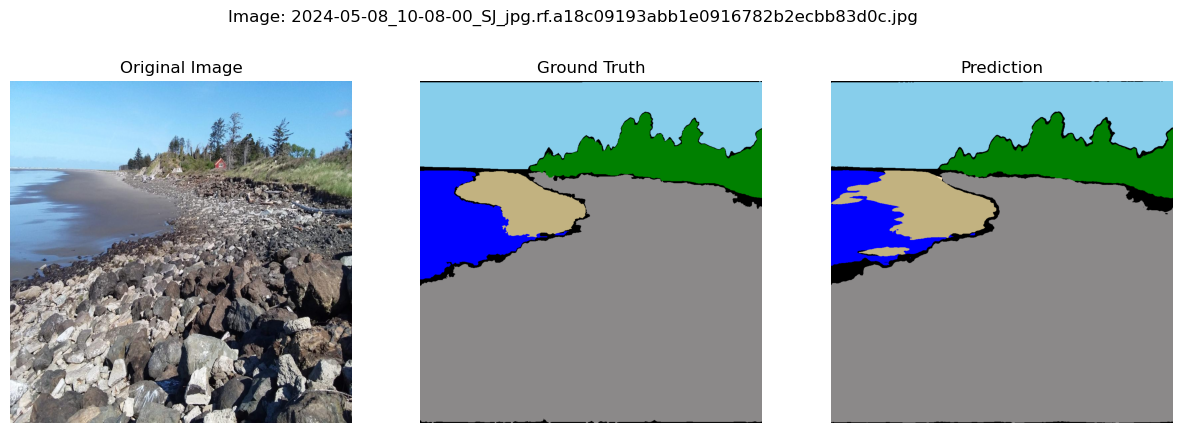

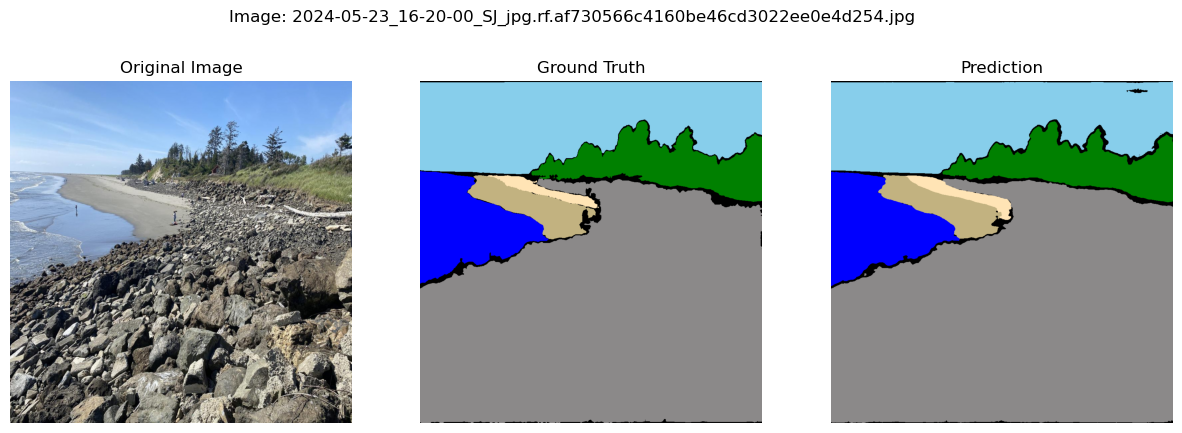

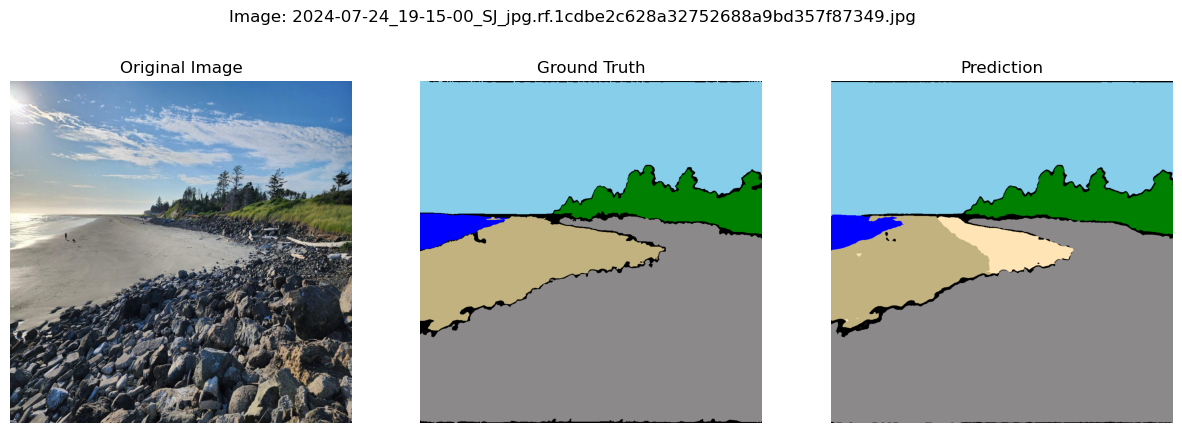

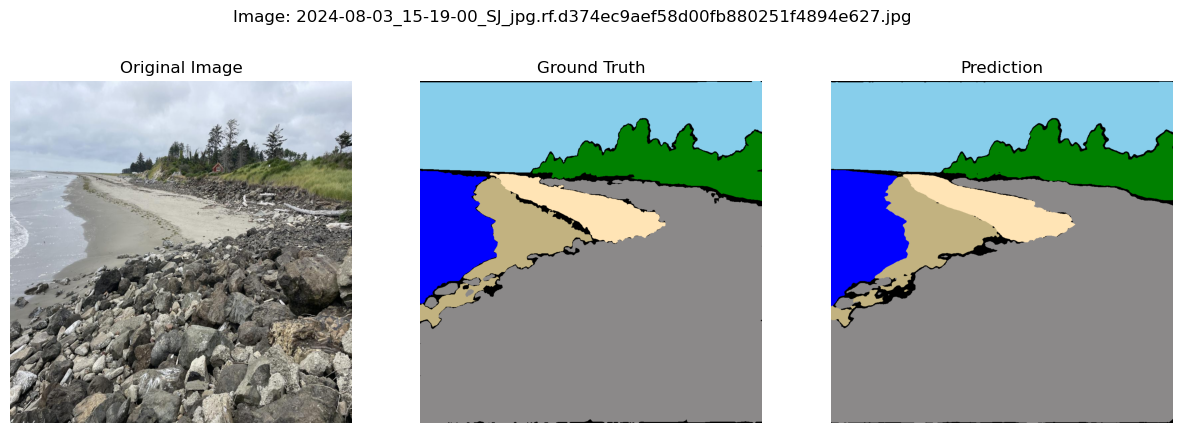

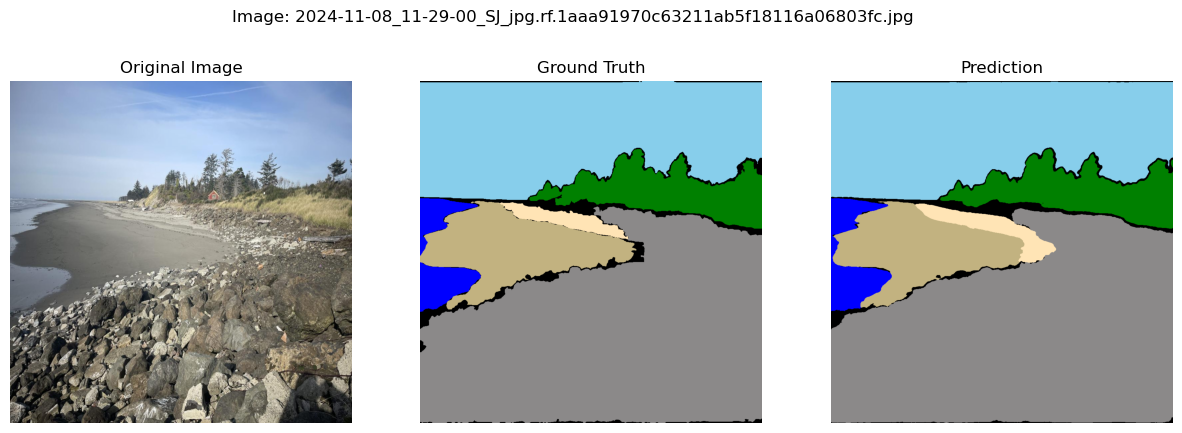

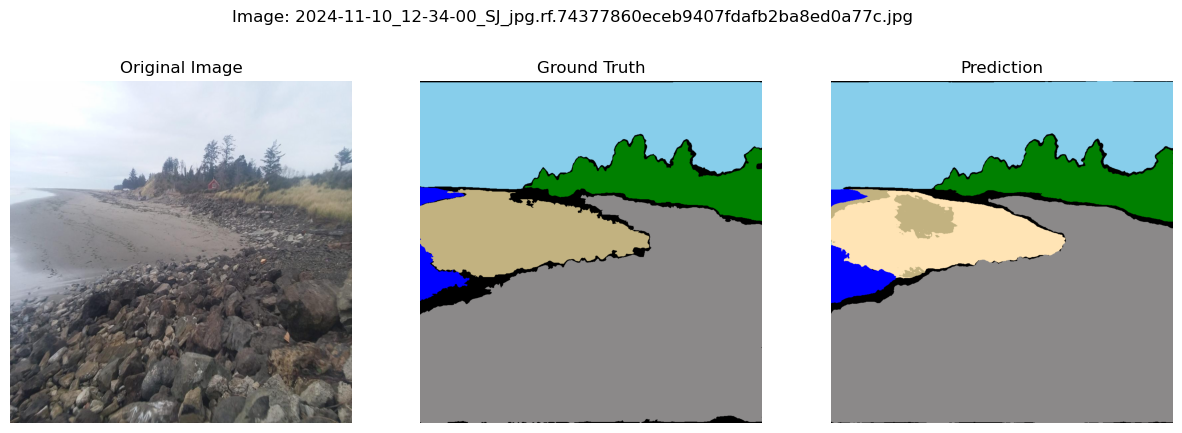

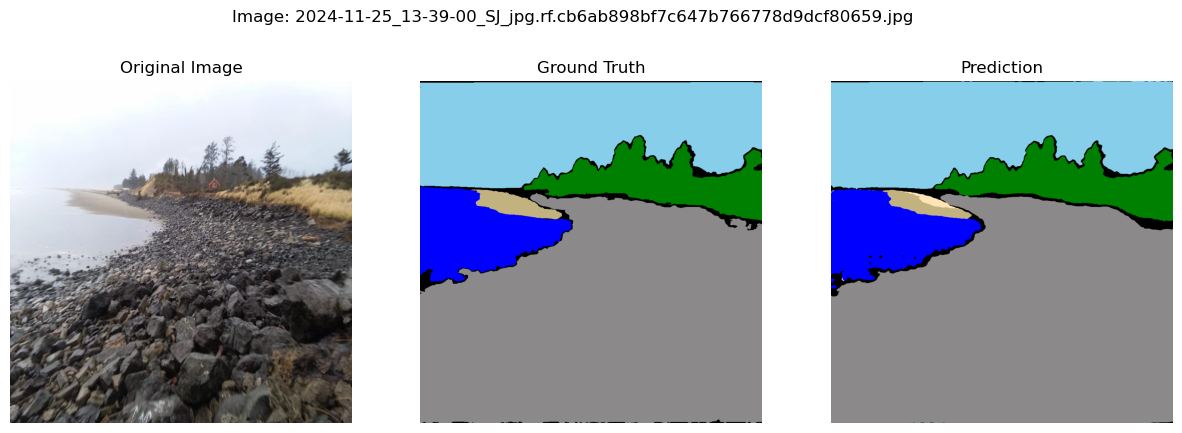

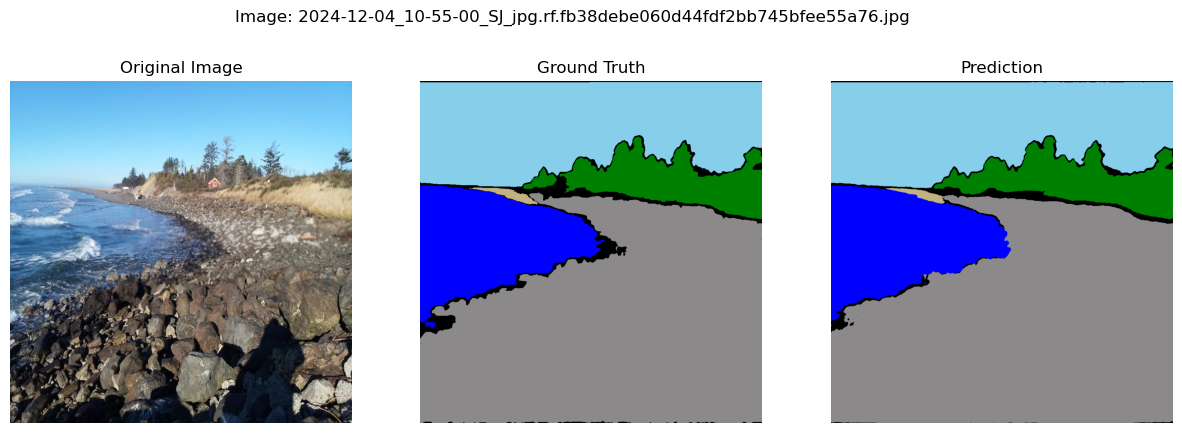

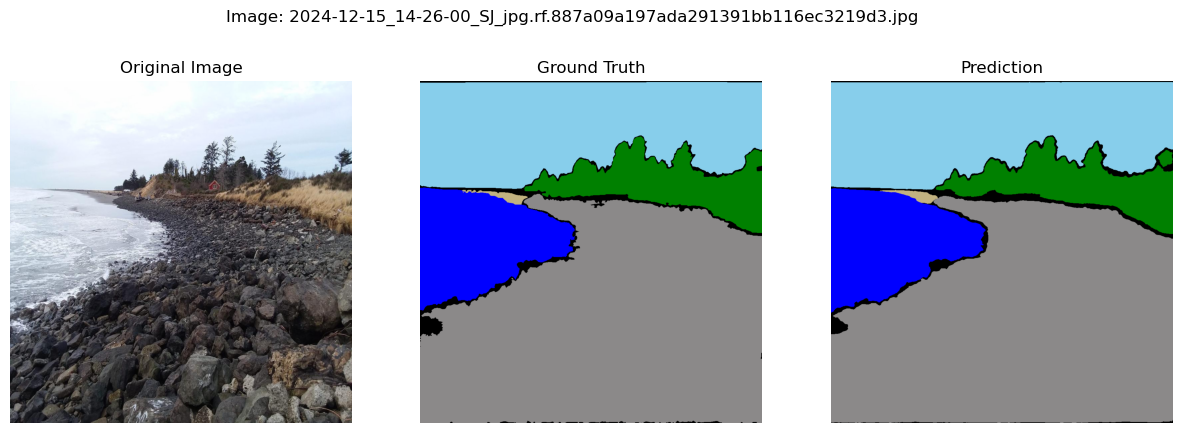

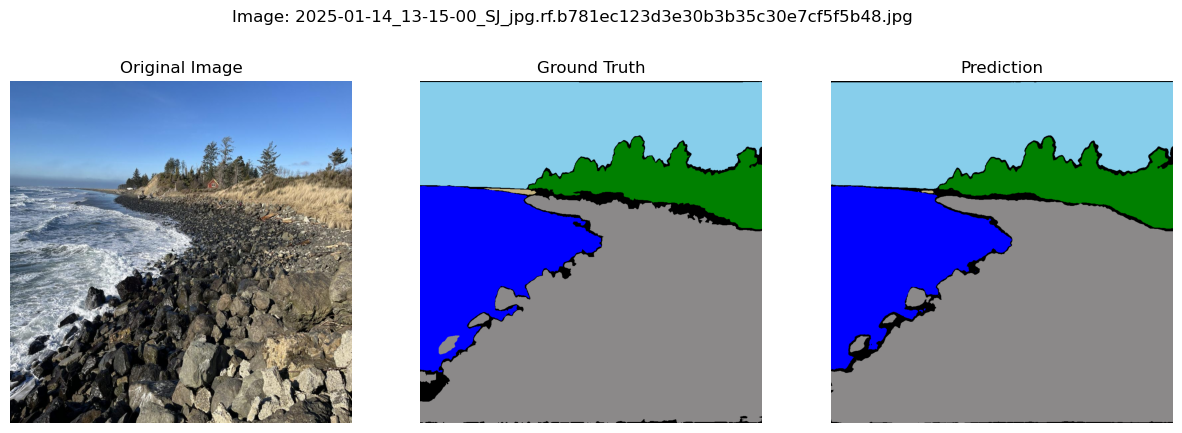

Processed 10/10 images
All test images processed and saved to test_predictions


In [2]:
# Code to visualize all test images in the test set using the trained model

import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def visualize_all_test_predictions(model_path, data_dir="data", image_size=1024, save_dir="test_predictions", display_images=True):
    """Visualize predictions for all images in the test set"""
    
    # Set device for inference
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load the trained model
    model = BeachSegmentationModel.load_from_checkpoint(model_path)
    model.eval()
    model.to(device)
    
    # Create test dataset
    x_test_dir = os.path.join(data_dir, "test")
    y_test_dir = os.path.join(data_dir, "test")
    test_dataset = BeachSegmentationDataset(
        x_test_dir, y_test_dir,
        augmentation=get_validation_augmentation(image_size),
    )
    
    # Create dataloader with batch_size=1 for visualization
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Create save directory if needed
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Processing {len(test_dataset)} test images...")
    
    # Process all test images
    with torch.no_grad():
        for i, (image, mask, filepath) in enumerate(test_loader):
            # Move data to device
            image = image.to(device)
            mask = mask.to(device)
            
            # Get model predictions
            logits = model(image)
            prob_mask = logits.softmax(dim=1)
            pred_mask = prob_mask.argmax(dim=1)
            
            # Convert tensors to numpy arrays
            image = image.cpu().numpy().squeeze().transpose(1, 2, 0)
            mask = mask.cpu().numpy().squeeze()
            pred_mask = pred_mask.cpu().numpy().squeeze()
            
            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            
            # Create color masks for visualization
            color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            color_pred_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
            
            for cls, color in test_dataset.COLOR_MAP.items():
                color_mask[mask == cls] = color
                color_pred_mask[pred_mask == cls] = color
            
            # Create visualization with three panels
            plt.figure(figsize=(15, 5))
            
            plt.subplot(131)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')
            
            plt.subplot(132)
            plt.imshow(color_mask)
            plt.title("Ground Truth")
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(color_pred_mask)
            plt.title("Prediction")
            plt.axis('off')
            
            # Get filename for title
            filename = os.path.basename(filepath[0])
            plt.suptitle(f"Image: {filename}")
            
            # Save visualization
            plt.savefig(os.path.join(save_dir, f"prediction_{filename}.png"))
            
            # Display in notebook if requested
            if display_images:
                plt.show()
            else:
                plt.close()
            
            # Print progress
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_dataset)} images")
    
    print(f"All test images processed and saved to {save_dir}")

# Main execution code
if __name__ == "__main__" or '__ipython__' in globals():
    # Find the best model checkpoint
    checkpoint_files = []
    for version_dir in glob.glob("lightning_logs/version_*"):
        checkpoints = glob.glob(f"{version_dir}/checkpoints/*.ckpt")
        checkpoint_files.extend(checkpoints)

    if checkpoint_files:
        # Use the most recent checkpoint
        best_model_path = sorted(checkpoint_files)[-1]
        print(f"Using model: {best_model_path}")
        
        # Visualize all test images
        visualize_all_test_predictions(
            best_model_path, 
            data_dir="data", 
            image_size=1024, 
            save_dir="test_predictions",
            display_images=True  # Set to False for large test sets to avoid notebook slowdown
        )
    else:
        print("No trained model found. Please train a model first.")